In [2]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from sionna.phy import Block
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, \
                            OFDMModulator, OFDMDemodulator, RZFPrecoder, RemoveNulledSubcarriers
from sionna.phy.channel.tr38901 import AntennaArray, CDL
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, \
                               time_lag_discrete_time_channel, ApplyOFDMChannel, ApplyTimeChannel, \
                               OFDMChannel, TimeChannel
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, BinarySource
from sionna.phy.utils import ebnodb2no, sim_ber, compute_ber

Average energy per pilot symbol: 1.00


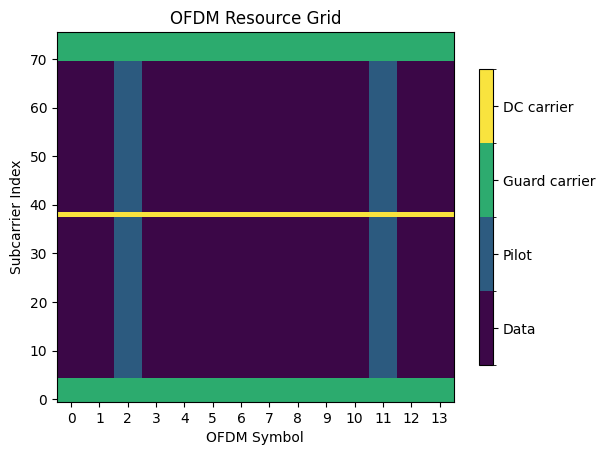

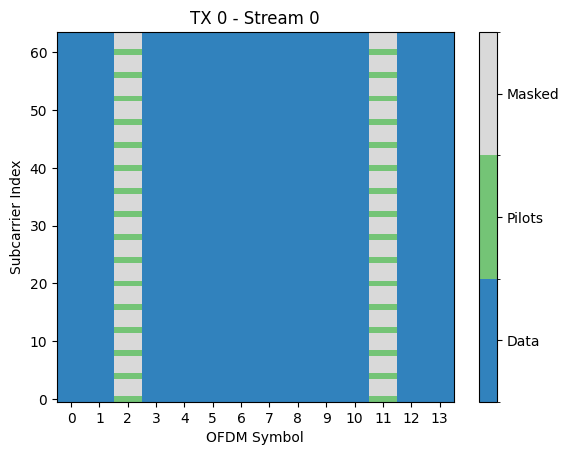

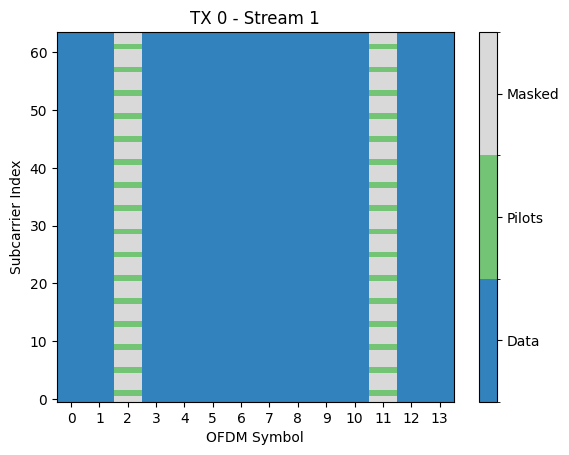

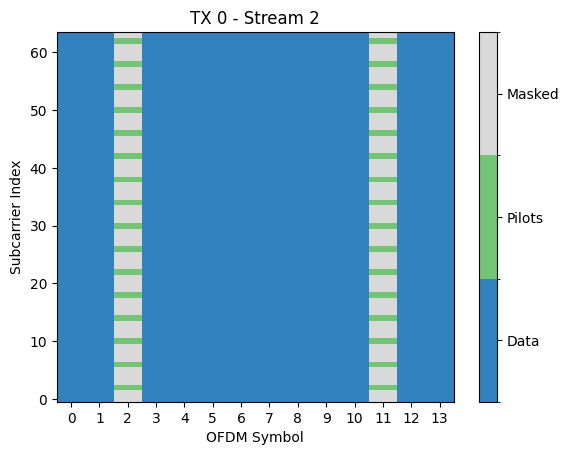

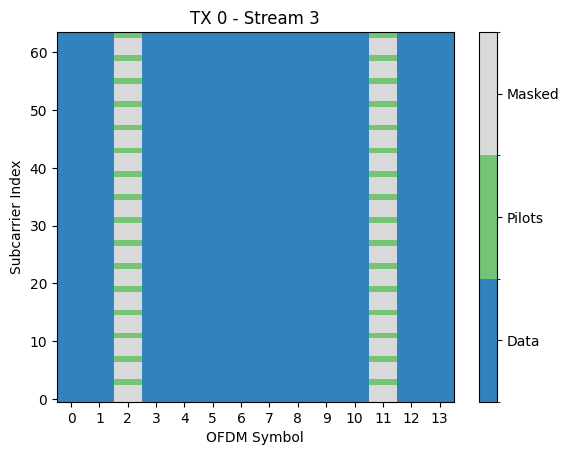

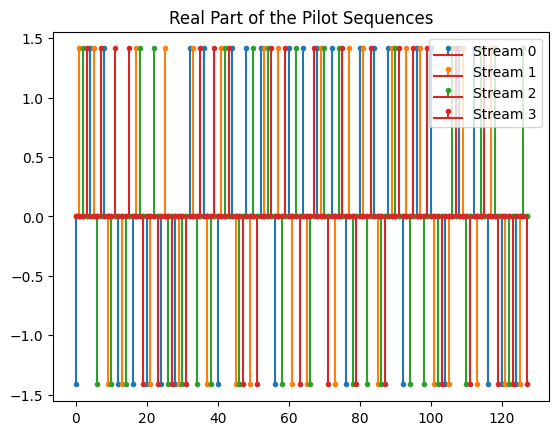

In [6]:
# Define the number of UT and BS antennas.
# For the CDL model, that will be used in this notebook, only
# a single UT and BS are supported.
num_ut = 1
num_bs = 1
num_ut_ant = 4
num_bs_ant = 8

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
num_streams_per_tx = num_ut_ant

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=76,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=6,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])
rg.show();
rg.pilot_pattern.show();

plt.figure()
plt.title("Real Part of the Pilot Sequences")
for i in range(num_streams_per_tx):
    plt.stem(np.real(rg.pilot_pattern.pilots[0, i]),
             markerfmt="C{}.".format(i), linefmt="C{}-".format(i),
             label="Stream {}".format(i))
plt.legend()
print("Average energy per pilot symbol: {:1.2f}".format(np.mean(np.abs(rg.pilot_pattern.pilots[0,0])**2)))




In [47]:
class Model(tf.keras.Model):
    """This block simulates OFDM MIMO transmissions over the CDL model.

    Simulates point-to-point transmissions between a UT and a BS.
    Uplink and downlink transmissions can be realized with either perfect CSI
    or channel estimation. ZF Precoding for downlink transmissions is assumed.
    The receiver (in both uplink and downlink) applies LS channel estimation
    and LMMSE MIMO equalization. A 5G LDPC code as well as QAM modulation are
    used.

    Parameters
    ----------
    domain : One of ["time", "freq"], str
        Determines if the channel is modeled in the time or frequency domain.
        Time-domain simulations are generally slower and consume more memory.
        They allow modeling of inter-symbol interference and channel changes
        during the duration of an OFDM symbol.

    direction : One of ["uplink", "downlink"], str
        For "uplink", the UT transmits. For "downlink" the BS transmits.

    cdl_model : One of ["A", "B", "C", "D", "E"], str
        The CDL model to use. Note that "D" and "E" are LOS models that are
        not well suited for the transmissions of multiple streams.

    delay_spread : float
        The nominal delay spread [s].

    perfect_csi : bool
        Indicates if perfect CSI at the receiver should be assumed. For downlink
        transmissions, the transmitter is always assumed to have perfect CSI.

    speed : float
        The UT speed [m/s].

    cyclic_prefix_length : int
        The length of the cyclic prefix in number of samples.

    pilot_ofdm_symbol_indices : list, int
        List of integers defining the OFDM symbol indices that are reserved
        for pilots.

    subcarrier_spacing : float
        The subcarrier spacing [Hz]. Defaults to 15e3.

    Input
    -----
    batch_size : int
        The batch size, i.e., the number of independent Mote Carlo simulations
        to be performed at once. The larger this number, the larger the memory
        requiremens.

    ebno_db : float
        The Eb/No [dB]. This value is converted to an equivalent noise power
        by taking the modulation order, coderate, pilot and OFDM-related
        overheads into account.

    Output
    ------
    b : [batch_size, 1, num_streams, k], tf.float32
        The tensor of transmitted information bits for each stream.

    b_hat : [batch_size, 1, num_streams, k], tf.float32
        The tensor of received information bits for each stream.
    """
    def __init__(self, domain, direction, cdl_model, delay_spread, perfect_csi, speed, cyclic_prefix_length, pilot_ofdm_symbol_indices, subcarrier_spacing=15e3):
        tf.keras.Model.__init__(self)
        # Provided parameters
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._perfect_csi = perfect_csi
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices

        # System parameters
        self._carrier_frequency = 2.6e9
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 72
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 4 # Must be a multiple of two as dual-polarized antennas are used
        self._num_bs_ant = 8 # Must be a multiple of two as dual-polarized antennas are used
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = [5, 6]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 2
        self._coderate = 0.5

        # Required system components
        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)

        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=1,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        self._k = int(self._n * self._coderate)

        self._ut_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_ut_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._cdl = CDL(model=self._cdl_model,
                        delay_spread=self._delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction=self._direction,
                        min_speed=self._speed)

        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)

        if self._domain == "freq":
            self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        elif self._domain == "time":
            self._l_min, self._l_max = time_lag_discrete_time_channel(self._rg.bandwidth)
            self._l_tot = self._l_max - self._l_min + 1
            self._channel_time = ApplyTimeChannel(self._rg.num_time_samples,
                                                  l_tot=self._l_tot,
                                                  add_awgn=True)
            self._modulator = OFDMModulator(self._cyclic_prefix_length)
            self._demodulator = OFDMDemodulator(self._fft_size, self._l_min, self._cyclic_prefix_length)

        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        if self._direction == "downlink":
            self._zf_precoder = RZFPrecoder(self._rg, self._sm, return_effective_channel=True)

        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)

    @tf.function # Run in graph mode. See the following guide: https://www.tensorflow.org/guide/function
    def call(self, batch_size, ebno_db):

        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        if self._domain == "time":
            # Time-domain simulations

            a, tau = self._cdl(batch_size, self._rg.num_time_samples+self._l_tot-1, self._rg.bandwidth)
            h_time = cir_to_time_channel(self._rg.bandwidth, a, tau,
                                         l_min=self._l_min, l_max=self._l_max, normalize=True)

            # As precoding is done in the frequency domain, we need to downsample
            # the path gains `a` to the OFDM symbol rate prior to converting the CIR
            # to the channel frequency response.
            a_freq = a[...,self._rg.cyclic_prefix_length:-1:(self._rg.fft_size+self._rg.cyclic_prefix_length)]
            a_freq = a_freq[...,:self._rg.num_ofdm_symbols]
            h_freq = cir_to_ofdm_channel(self._frequencies, a_freq, tau, normalize=True)

            if self._direction == "downlink":
                x_rg, g = self._zf_precoder(x_rg, h_freq)

            x_time = self._modulator(x_rg)
            y_time = self._channel_time(x_time, h_time, no)

            y = self._demodulator(y_time)

        elif self._domain == "freq":
            # Frequency-domain simulations

            cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
            h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)

            if self._direction == "downlink":
                x_rg, g = self._zf_precoder(x_rg, h_freq)

            y = self._channel_freq(x_rg, h_freq, no)

        if self._perfect_csi:
            if self._direction == "uplink":
                h_hat = self._remove_nulled_scs(h_freq)
            elif self._direction =="downlink":
                h_hat = g
            err_var = 0.0
        else:
            h_hat, err_var = self._ls_est (y, no)

        x_hat, no_eff = self._lmmse_equ(y, h_hat, err_var, no)
        llr = self._demapper(x_hat, no_eff)
        b_hat = self._decoder(llr)

        return b, b_hat

In [ ]:
UL_SIMS = {
    "ebno_db" : list(np.arange(-5, 20, 4.0)),
    "cdl_model" : ["A", "B", "C", "D", "E"],
    "delay_spread" : 100e-9,
    "domain" : "freq",
    "direction" : "uplink",
    "perfect_csi" : True,
    "speed" : 0.0,
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for cdl_model in UL_SIMS["cdl_model"]:

    model = Model(domain=UL_SIMS["domain"],
                  direction=UL_SIMS["direction"],
                  cdl_model=cdl_model,
                  delay_spread=UL_SIMS["delay_spread"],
                  perfect_csi=UL_SIMS["perfect_csi"],
                  speed=UL_SIMS["speed"],
                  cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"])

    ber, bler = sim_ber(model,
                        UL_SIMS["ebno_db"],
                        batch_size=256,
                        max_mc_iter=100,
                        num_target_block_errors=1000,
                        target_bler=1e-3)

    UL_SIMS["ber"].append(list(ber.numpy()))
    UL_SIMS["bler"].append(list(bler.numpy()))

UL_SIMS["duration"] = time.time() - start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 1.2153e-01 | 5.7666e-01 |      179203 |     1474560 |         1181 |        2048 |        23.5 |reached target block errors
     -1.0 | 5.9608e-02 | 3.2300e-01 |      175790 |     2949120 |         1323 |        4096 |        19.9 |reached target block errors
      3.0 | 1.9645e-02 | 1.1936e-01 |      130355 |     6635520 |         1100 |        9216 |        41.5 |reached target block errors
      7.0 | 5.1761e-03 | 3.5052e-02 |      106855 |    20643840 |         1005 |       28672 |       126.4 |reached target block errors
     11.0 | 9.6042e-04 | 7.3340e-03 |       70810 |    73728000 |          751 |      102400 |       491.6 |reached max iterations


In [48]:
import pickle as pickle
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = -2
ebno_db_max = 4

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 1000 #10000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700 #7000
num_training_iterations_rl_finetuning = 300 #3000
###############################################
# Meta-RL Training configuration
###############################################
num_training_iterations_meta_rl = 500 #1000 # Number of training iterations for Meta-RL training
meta_batch_size = 8 # Number of tasks for each meta-training iteration

training_batch_size = tf.constant(32, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done
model_weights_path_metarl_training = "awgn_autoencoder_weights_metarl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path + "__rf", 'wb') as f:
        pickle.dump(weights, f)

# Utility function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path + "__rf", 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

num_tx = 4
num_rx = 16

In [49]:
class NeuralDemapper(tf.keras.Model):
    def __init__(self, num_hidden=128, num_bits_per_symbol=2, max_num_data_symbols=1008):
        super().__init__()
        self.num_bits_per_symbol = num_bits_per_symbol
        self.max_num_data_symbols = max_num_data_symbols
        self.dense1 = tf.keras.layers.Dense(num_hidden, activation='relu')
        self.dense2 = tf.keras.layers.Dense(num_hidden, activation='relu')
        # Output layer: flatten all LLRs, then reshape later
        self.out = tf.keras.layers.Dense(max_num_data_symbols * num_bits_per_symbol, activation=None)

        # Build the model with a fixed input shape
        dummy_y = tf.zeros([1, max_num_data_symbols], dtype=tf.complex64)
        dummy_no = tf.zeros([1, 1], dtype=tf.float32)
        self.call(dummy_y, dummy_no)

    def call(self, y_flat, no_flat):
        # y_flat: [batch, max_num_data_symbols]
        # no_flat: [batch, 1]
        x = tf.concat([tf.math.real(y_flat), tf.math.imag(y_flat), no_flat], axis=-1)
        x = self.dense1(x)
        x = self.dense2(x)
        llr = self.out(x)  # [batch, max_num_data_symbols * num_bits_per_symbol]
        # Reshape to [batch, max_num_data_symbols, num_bits_per_symbol]
        llr = tf.reshape(llr, [-1, self.max_num_data_symbols, self.num_bits_per_symbol])
        return llr

In [65]:
from tqdm import tqdm
class E2ESystemCDL(Model):
    """
    End-to-end system for CDL channel with a trainable neural demapper.
    Uses fixed resource grid configuration for consistent data symbol count.
    """

    def __init__(self, domain="freq", direction="uplink", cdl_model="A", delay_spread=100e-9,
                 perfect_csi=True, speed=0.0, cyclic_prefix_length=6, pilot_ofdm_symbol_indices=[2, 11],
                 subcarrier_spacing=15e3, training=True):
        Model.__init__(
            self,
            domain=domain,
            direction=direction,
            cdl_model=cdl_model,
            delay_spread=delay_spread,
            perfect_csi=perfect_csi,
            speed=speed,
            cyclic_prefix_length=cyclic_prefix_length,
            pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices,
            subcarrier_spacing=subcarrier_spacing
        )
        self.training = training

        # System parameters - fixed for consistent data symbols
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._perfect_csi = perfect_csi
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = [2, 11]  # Fixed pilot positions
        self._subcarrier_spacing = subcarrier_spacing
        
        # Resource grid and channel setup with fixed configuration
        self._carrier_frequency = 2.6e9
        self._fft_size = 72
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 4
        self._num_bs_ant = 8
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = [5, 6]
        self._pilot_pattern = "kronecker"
        self._num_bits_per_symbol = 2
        self._coderate = 0.5
        
        # Pre-computed fixed data symbols: (72-11-1)*(14-2) = 60*12 = 720
        self.fixed_data_symbols = 720

        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)
        self._rg = ResourceGrid(
            num_ofdm_symbols=self._num_ofdm_symbols,
            fft_size=self._fft_size,
            subcarrier_spacing=self._subcarrier_spacing,
            num_tx=1,
            num_streams_per_tx=self._num_streams_per_tx,
            cyclic_prefix_length=self._cyclic_prefix_length,
            num_guard_carriers=self._num_guard_carriers,
            dc_null=self._dc_null,
            pilot_pattern=self._pilot_pattern,
            pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices
        )
        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        self._k = int(self._n * self._coderate)

        # Antenna arrays and CDL channel
        self._ut_array = AntennaArray(
            num_rows=1,
            num_cols=int(self._num_ut_ant/2),
            polarization="dual",
            polarization_type="cross",
            antenna_pattern="38.901",
            carrier_frequency=self._carrier_frequency
        )
        self._bs_array = AntennaArray(
            num_rows=1,
            num_cols=int(self._num_bs_ant/2),
            polarization="dual",
            polarization_type="cross",
            antenna_pattern="38.901",
            carrier_frequency=self._carrier_frequency
        )
        self._cdl = CDL(
            model=self._cdl_model,
            delay_spread=self._delay_spread,
            carrier_frequency=self._carrier_frequency,
            ut_array=self._ut_array,
            bs_array=self._bs_array,
            direction=self._direction,
            min_speed=self._speed
        )
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        # Source, encoder, mapper
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        # Neural demapper with fixed data symbols size
        self._neural_demapper = NeuralDemapper(max_num_data_symbols=self.fixed_data_symbols)
        
        # Loss
        if self.training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    def call(self, batch_size, ebno_db):
        # Eb/No to noise power
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        # Source and encoding
        if self.training:
            c = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._n])
        else:
            b = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._k])
            c = self._encoder(b)

        # Mapping and resource grid
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        # CDL channel (frequency domain)
        cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
        h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)
        y = self._channel_freq(x_rg, h_freq, no)
        print(f"The data in y is: ", y.shape)

        # y: [batch, 1, streams, ofdm_symbols, subcarriers]
        # Remove singleton dimension if present
        y_squeezed = tf.squeeze(y, axis=1)  # [batch, streams, ofdm_symbols, subcarriers]
        batch_size = tf.shape(y_squeezed)[0]
        num_streams = tf.shape(y_squeezed)[1]

        # Build a mask of shape [ofdm_symbols, fft_size] where True = data
        data_mask = np.ones((self._num_ofdm_symbols, self._fft_size), dtype=bool)

        # Mask out guard carriers
        if self._num_guard_carriers[0] > 0:
            data_mask[:, :self._num_guard_carriers[0]] = False
        if self._num_guard_carriers[1] > 0:
            data_mask[:, -self._num_guard_carriers[1]:] = False

        # Mask out DC
        if self._dc_null:
            dc_idx = self._fft_size // 2
            data_mask[:, dc_idx] = False

        # Mask out pilots (Kronecker structure: all subcarriers for each stream in pilot symbols)
        for sym_idx in self._pilot_ofdm_symbol_indices:
            if sym_idx < self._num_ofdm_symbols:
                data_mask[sym_idx, :] = False

        # Now data_mask is True for data positions
        flat_mask = data_mask.flatten()

        # Reshape y to [batch, streams, num_ofdm_symbols * fft_size]
        y_reshaped = tf.reshape(y_squeezed, [batch_size, num_streams, self._num_ofdm_symbols * self._fft_size])
        y_data = tf.boolean_mask(y_reshaped, flat_mask, axis=2)  # [batch, streams, num_data_symbols]
        y_flat = tf.reshape(y_data, [batch_size, -1])
        no_flat = tf.ones([batch_size, 1], dtype=no.dtype) * no

        num_symbols = tf.shape(y_flat)[1]
        print(num_symbols)

        # Pad to fixed size (should always be the same with fixed configuration)
        pad_len = self.fixed_data_symbols - num_symbols
        y_flat_padded = tf.pad(y_flat, [[0, 0], [0, pad_len]])
        
        llr = self._neural_demapper(y_flat_padded, no_flat)
        llr = llr[:, :num_symbols, :]  # Remove padding after demapper
        llr = tf.reshape(llr, [batch_size, -1])
        
        if self.training:
            # BCE loss on coded bits
            c_flat = tf.reshape(tf.cast(c, tf.float32), [batch_size, -1])
            loss = self._bce(c_flat, llr)
            return loss
        else:
            # Outer decoding for evaluation
            b_hat = self._decoder(llr)
            b = tf.reshape(tf.cast(b, tf.float32), [batch_size, -1])
            return b, b_hat

# --- Training function ---

def train_e2e_cdl(model, num_iterations=1000, batch_size=32, ebno_db_min=0.0, ebno_db_max=10.0):
    optimizer = tf.keras.optimizers.Adam()
    batch_size = tf.constant(batch_size, tf.int32)
    @tf.function
    def train_step():
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        with tf.GradientTape() as tape:
            loss = model(batch_size, ebno_db)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    for i in tqdm(range(num_iterations)):
        loss = train_step()
        if i % 100 == 0:
            print(f"Iteration {i}/{num_iterations}  BCE: {loss.numpy():.4f}", end='\r')
    print("\nTraining complete.")

# Example usage:
model = E2ESystemCDL(training=True)
train_e2e_cdl(model, num_iterations=1000, batch_size=32)

  0%|          | 0/1000 [00:00<?, ?it/s]

The data in y is:  (32, 1, 8, 14, 72)
Tensor("strided_slice_103:0", shape=(), dtype=int32)
The data in y is:  (32, 1, 8, 14, 72)
Tensor("e2e_system_cdl_19_1/strided_slice_103:0", shape=(), dtype=int32)
The data in y is:  (32, 1, 8, 14, 72)
Tensor("e2e_system_cdl_19_1/strided_slice_103:0", shape=(), dtype=int32)


  0%|          | 0/1000 [00:17<?, ?it/s]


InvalidArgumentError: Graph execution error:

Detected at node e2e_system_cdl_19_1/Pad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Ahmad\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\Ahmad\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\Ahmad\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code

  File "C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10012\2453404876.py", line 209, in <module>

  File "C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10012\2453404876.py", line 202, in train_e2e_cdl

  File "C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10012\3746998527.py", line 196, in train_step

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\keras\src\layers\layer.py", line 908, in __call__

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "e:\Projects\Unfinished\Sionna-CDL-Channel\.env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10012\2453404876.py", line 170, in call

Paddings must be non-negative: 0 -5040
	 [[{{node e2e_system_cdl_19_1/Pad}}]] [Op:__inference_train_step_249367]